In [237]:
%run load-clean-select.ipynb

Morphology was measured for 610.0 cells.

The numbers of cells and nuclei correspond to each other.

The are no duplicated column names: True
The are no duplicated column names: True
Cytoplasm measurements were taken for 610 cells.

The are no duplicated column names: True
Read biomarkers normalised by to min gain
Biomarkers were measured for 610 cells.

The are no duplicated column names: True

Full dataset has shape: (610, 484)
Initial shape is: (610, 484)
Features with zero variance:
 Index(['centerZ_cell', 'eulernumber_cell', 'children_cytoplasm_count_cell',
       'loc_centermassintensityZ_wga', 'loc_centerZ_cell',
       'loc_maxintensityZ_wga', 'centerZ_nucl', 'eulernumber_nucl',
       'children_cells_count', 'children_cytoplasm_count_nucl',
       'loc_centermassintensityZ_dapi', 'loc_centerZ_nucl',
       'loc_maxintensityZ_dapi', 'centerZ_cyto',
       'loc_centermassintensityZ_ker', 'loc_centermassintensityZ_vim',
       'loc_centerZ', 'loc_maxintensityZ_ker', 'loc_maxinten

# Which dataset?

In [238]:
# The full dataset
# df = measurements
# Dataset without clusters at 64kPa
# df_ = measurements_red
# Dataset without 0.5kPa, 8kPa and clusters at 64kPa
df_ = measurements_5
# Dataset without 0.5kPa, 8kPa and clusters at 64kPa with balanced classes
# df_ = measurements_b

# Some functions

In [239]:
# Prepare a vector of colours mapped to the 'stiffness' column
def create_palette(df, by='stiffness', show=False):
    if by == 'stiffness':
        n_levels = df.stiffness.unique().size
        palette = dict(zip(df.stiffness.unique(), sns.color_palette("Set3", n_levels)))
        row_colors = df.stiffness.map(palette)
    elif by == 'cluster':
        n_levels = df.cluster.unique().size
        if n_levels == 2:
            palette = {1 : sns.color_palette("PRGn", 20)[15], 2 : sns.color_palette("PRGn", 20)[4]}
        else:
            palette = dict(zip(range(n_levels), sns.color_palette("PRGn", n_levels)))
        row_colors = df.cluster.map(palette)
    elif by == 'biom':
        palette = {df.biom.unique()[0] : sns.color_palette("RdBu", 10)[1],
                   df.biom.unique()[1] : sns.color_palette("RdBu", 10)[8]}
        row_colors = df.biom.map(palette)
        
    if show:
#         print(list(palette.keys()))
        sns.palplot(palette.values());
    
    return row_colors, palette
# plt.savefig('../results/My palette.png', bbox_inches='tight', dpi=300);

In [240]:
def drop_outliers_iqr(df, col):
    df_ = df.copy()
    for s in df.stiffness.unique():
        x = df[df.stiffness == s][col]
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df_.drop(x.loc[(x < lower) | (x > upper)].index, inplace=True)
    return df_

In [241]:
from scipy import stats

def norm_tests(x):
    
    alpha = 0.05
    
    nm_stat, nm_p = stats.normaltest(x)
    print("D’Agostino-Pearson:")
    if nm_p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
        
    jb_stat, jb_p = stats.jarque_bera(x)
    print("\nJarque-Bera:")
    if jb_p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
        
    sw_stat, sw_p = stats.shapiro(x)
    print("\nShapiro-Wilk:")
    if jb_p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

    
    results = [('D’Agostino-Pearson', nm_stat, nm_p),
               ('Jarque-Bera', jb_stat, jb_p), 
               ('Shapiro-Wilk', sw_stat, sw_p)
              ]
    results = pd.DataFrame(results, columns=['Test name', 'Statistic', 'p-value'])
    return results

In [242]:
def boxcox_transform(df, col, verbose=0):
    new_col = col + '_t'
    df[new_col] = 'NA'
    for s in df.stiffness.unique():
        print("Stiffness: ", s)
        norm_tests(df.loc[df.stiffness == s, col], 'original', verbose)
        xt, maxlog = stats.boxcox(df.loc[df.stiffness == s, col])
        print("Argmax log likelyhood:", maxlog)
        norm_tests(xt, 'transformed', verbose)
        df.loc[df.stiffness == s, new_col] = xt

    sns.boxplot(x=df.stiffness, y=df[col], palette=palette);
    plt.title('Original data')
    plt.figure()
    sns.boxplot(x=df.stiffness, y=df[new_col], palette=palette);
    plt.title('Transformed data')

In [243]:
def plot_intensities(df, col, kind, data, ylim, size=(6,4), ci='sd', add_line=False):
    plt.rcParams['figure.figsize'] = size

    row_colors, palette = create_palette(df)               
    
    if kind == 'barplot':
        sns.barplot(x=df.stiffness, y=df[col],
                    ci=ci, capsize=.1, palette=palette);
        if add_line:
            sns.lineplot(x=df.stiffness, y=df[col],
                         ci=95, linewidth=3, color='orangered');
    if kind == 'boxplot':
        sns.boxplot(x=df.stiffness, y=df[col],
                    width = 0.6, palette=palette, showfliers=False);
        if add_line:
            sns.lineplot(x=df.stiffness, y=df[col],
                         ci=95, linewidth=3, color='orangered');
    plt.xlabel("Stiffness, kPa");
    plt.ylim(ylim);
    
    if data == 'mean':
        plt.ylabel("Mean intensity, a.u.");
        s = "MI"
    elif data == 'int':
        plt.ylabel("Integrated intensity, a.u.");
        s = "II"
    elif data == 'ctcf':
        plt.ylabel("CTCF, a.u.");
        s = "CTCF"
    else:
        plt.ylabel("Ratio, a.u.")
        s = ""
    
    if col == 'ker':
        plt.title("Cytokeratins");
        plt.savefig('../results/Ker '+ s +' '+ kind +'.png', bbox_inches='tight', dpi=300);
    elif col == 'vim':
        plt.title("Vimentin");
        plt.savefig('../results/Vim '+ s +' '+ kind +'.png', bbox_inches='tight', dpi=300);
    elif col == 'cvratio':
        plt.title("Cytokeratins to Vimentin ratio");
        plt.savefig('../results/CVR '+ s +' '+ kind +'.png', bbox_inches='tight', dpi=300);

# Correlations

In [ ]:
# Create numeric stiffness variable and define feature columns
df_['stiffness_num'] = pd.to_numeric(df_.stiffness)
# df['stiffness_log2'] = np.log2(df.stiffness_num)

## Pearson's correlation

In [ ]:
p_corr = df_[biom_cols].corrwith(df_.stiffness_num)
p_corr.abs().sort_values(ascending=False).head(10)

In [ ]:
plt.rcParams['figure.figsize'] = (15, 2)

sns.heatmap(pd.DataFrame(p_corr, columns=['Pearsons']).T, 
            cmap=sns.color_palette("RdBu_r", 100), 
            vmin=-1, vmax=1);

#plt.savefig('../results/Corr with Stiffness SMOTE.png', bbox_inches='tight', dpi=300);

## Spearman's correlation

In [ ]:
s_corr = df_[biom_cols].corrwith(df_.stiffness_num, method='spearman')
s_corr.abs().sort_values(ascending=False).head(10)

In [ ]:
sns.lmplot(x='stiffness_num', y='infomeas1_ker_00', data=df_, order=1);

# Intensity

###### Create a df with  intensities

In [ ]:
# Mean intensity
df = df_.loc[:, ['stiffness', 'meanintensity_ker', 'meanintensity_vim', 'cvratio', 'log_cvratio']].copy()
df.columns=['stiffness', 'ker', 'vim', 'cvratio', 'log_cvratio']

In [ ]:
# Integrated intensity
df = df_.loc[:, ['stiffness', 'integratedintensity_ker', 'integratedintensity_vim', 'cvratio', 'log_cvratio']].copy()
df.columns=['stiffness', 'ker', 'vim', 'cvratio', 'log_cvratio']

In [232]:
# CTCF
df = df_.loc[:, ['stiffness', 'ctcf_ker', 'ctcf_vim', 'cvratio', 'log_cvratio']].copy()
df.columns=['stiffness', 'ker', 'vim', 'cvratio', 'log_cvratio']
df.head()

,stiffness,ker,vim,cvratio,log_cvratio
0,0.2,4341.887762,1111.164058,3.907513,1.362901
1,0.2,1775.356443,1274.527764,1.392952,0.331425
2,0.2,906.637359,740.900368,1.223697,0.201876
3,0.2,2769.161701,1534.457834,1.804652,0.590368
4,0.2,1380.834124,342.445134,4.032278,1.394332


In [259]:
# CTCF
df = df_.loc[:, ['stiffness', 'well','ctcf_ker', 'ctcf_vim', 'cvratio', 'log_cvratio']].copy()
df.columns=['stiffness', 'well', 'ker', 'vim', 'cvratio', 'log_cvratio']
df.head()

,stiffness,well,ker,vim,cvratio,log_cvratio
0,0.2,A1,1442.325422,1466.148680,0.983751,-0.016382
1,0.2,A1,2769.161701,1534.457834,1.804652,0.590368
2,0.2,A1,2912.407184,630.713246,4.617641,1.529884
3,0.2,A1,5979.667244,1149.913238,5.200103,1.648678
4,0.2,A1,1160.795192,2529.939653,0.458823,-0.779090


In [266]:
df_agg = df.groupby(['stiffness', 'well']).ker.mean().unstack()
df_agg.reset_index(inplace=True)
df_agg = pd.melt(df_agg, id_vars=['stiffness'], value_vars=['A1', 'A2', 'A3'])
df_agg

,stiffness,well,value
0,0.2,A1,3535.892363
1,2.0,A1,2813.130139
2,16.0,A1,3872.012102
3,32.0,A1,4869.950196
4,64.0,A1,4705.316071
5,0.2,A2,2444.428697
6,2.0,A2,2485.344929
7,16.0,A2,3488.971931
8,32.0,A2,5949.534411
9,64.0,A2,6779.330351


In [275]:
np.mean([3535, 2444, 3122]), np.std([3535, 2444, 3122])

(3033.6666666666665, 449.75721845853184)

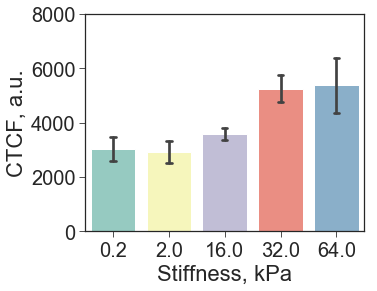

In [278]:
plot_intensities(df_agg, 'value', 'barplot', 'ctcf', [0, 8000], size=(5, 4), ci='sd', add_line=False)

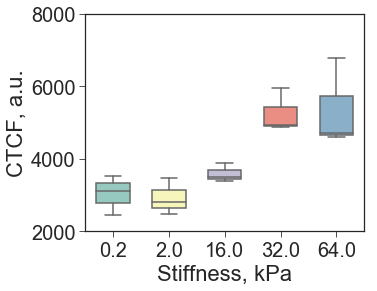

In [270]:
# sns.boxplot(x=df_agg.stiffness, y=df_agg.value, width = 0.6, showfliers=False);
plot_intensities(df_agg, 'value', 'boxplot', 'ctcf', [2000, 8000],  size=(5, 4), add_line=False)

###### Boxcox transformation

In [124]:
from sklearn.preprocessing import PowerTransformer

X = df[['ker', 'vim']]
powertf = PowerTransformer(copy=False)
powertf.fit(X)
df[['ker', 'vim']] = powertf.transform(X)
df.head()

,stiffness,ker,vim,cvratio,log_cvratio
0,0.2,0.381068,-0.336452,3.907513,1.362901
1,0.2,-0.694368,-0.118429,1.392952,0.331425
2,0.2,-1.423478,-0.929126,1.223697,0.201876
3,0.2,-0.175519,0.191700,1.804652,0.590368
4,0.2,-0.974589,-1.871144,4.032278,1.394332


###### Synthetic biomarker data

In [ ]:
df = proc.smote(df[['ker', 'vim']], df.stiffness)

## Normalise intensity to have an average of 1 at 0.2 kPa

In [199]:
df['kernorm'] = df.ker / df[df.stiffness == '0.2'].ker.mean()
df[df.stiffness == '0.2'].kernorm.mean()

1.0000000000000002

## Cytokeratins

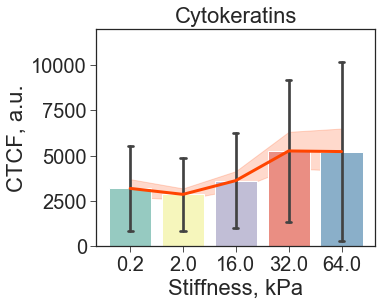

In [280]:
plot_intensities(df, 'ker', 'barplot', 'ctcf', [0, 12000], size=(5, 4), add_line=True)

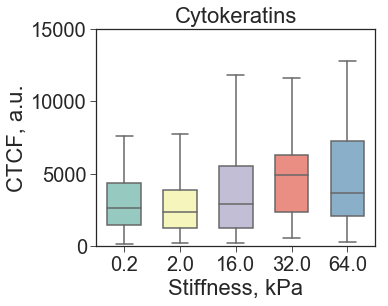

In [281]:
plot_intensities(df, 'ker', 'boxplot', 'ctcf',[0, 15000],  size=(5, 4), add_line=False)

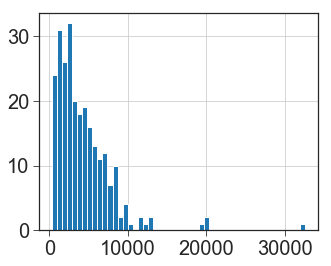

In [164]:
df.ker.hist(bins=50);

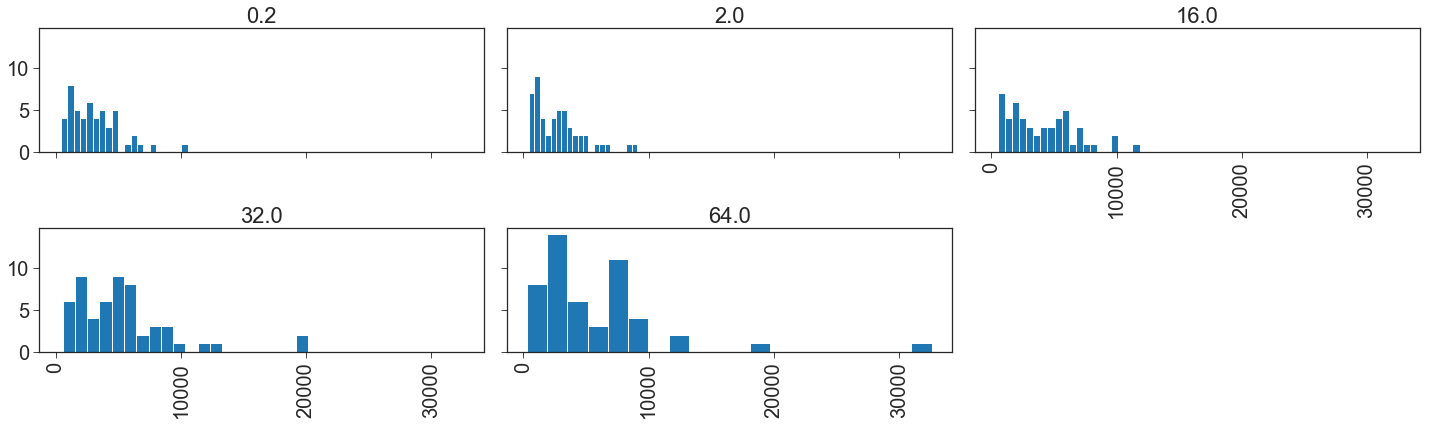

In [165]:
df.hist(column='ker', by='stiffness', bins=20, 
        sharex=True, sharey=True, 
        layout=(2, 3), 
        figsize=(20, 6));
plt.tight_layout()

In [166]:
df_[df_.ctcf_ker > 30000]

,label,image,object,combination,site,stiffness,well,area_cell,compactness_cell,eccentricity_cell,extent_cell,formfactor_cell,majoraxislength_cell,meanradius_cell,minoraxislength_cell,orientation_cell,perimeter_cell,solidity_cell,zernike_0_0_cell,zernike_1_1_cell,zernike_2_0_cell,zernike_2_2_cell,zernike_3_1_cell,zernike_3_3_cell,zernike_4_0_cell,zernike_4_2_cell,zernike_4_4_cell,zernike_5_1_cell,zernike_5_3_cell,zernike_5_5_cell,zernike_6_0_cell,zernike_6_2_cell,zernike_6_4_cell,zernike_6_6_cell,zernike_7_1_cell,zernike_7_3_cell,zernike_7_5_cell,zernike_7_7_cell,zernike_8_0_cell,zernike_8_2_cell,zernike_8_4_cell,zernike_8_6_cell,zernike_8_8_cell,zernike_9_1_cell,zernike_9_3_cell,zernike_9_5_cell,zernike_9_7_cell,zernike_9_9_cell,integratedintensityedge_wga,lowerquartileintensity_wga,maxintensityedge_wga,maxintensity_wga,meanintensityedge_wga,meanintensity_wga,minintensity_wga,stdintensity_wga,neighbors_anglebetweenneighbors_3,neighbors_firstclosestdistance_3,neighbors_numberofneighbors_3,neighbors_numberofneighbors_30,neighbors_percenttouching_3,neighbors_percenttouching_30,neighbors_secondclosestdistance_3,angularsecondmoment_wga_00,contrast_wga_00,contrast_wga_02,correlation_wga_00,correlation_wga_01,correlation_wga_02,correlation_wga_03,differenceentropy_wga_00,differencevariance_wga_00,entropy_wga_02,infomeas1_wga_00,infomeas1_wga_01,infomeas1_wga_02,infomeas1_wga_03,infomeas2_wga_00,infomeas2_wga_01,infomeas2_wga_02,infomeas2_wga_03,area_nucl,compactness_nucl,eccentricity_nucl,extent_nucl,formfactor_nucl,majoraxislength_nucl,meanradius_nucl,orientation_nucl,solidity_nucl,zernike_0_0_nucl,zernike_1_1_nucl,zernike_2_0_nucl,zernike_2_2_nucl,zernike_3_1_nucl,zernike_3_3_nucl,zernike_4_0_nucl,zernike_4_2_nucl,zernike_4_4_nucl,zernike_5_1_nucl,zernike_5_3_nucl,zernike_5_5_nucl,zernike_6_0_nucl,zernike_6_2_nucl,zernike_6_4_nucl,zernike_6_6_nucl,zernike_7_1_nucl,zernike_7_3_nucl,zernike_7_5_nucl,zernike_7_7_nucl,zernike_8_0_nucl,zernike_8_2_nucl,zernike_8_4_nucl,zernike_8_6_nucl,zernike_8_8_nucl,zernike_9_1_nucl,zernike_9_3_nucl,zernike_9_5_nucl,zernike_9_7_nucl,zernike_9_9_nucl,integratedintensityedge_dapi,madintensity_dapi,maxintensityedge_dapi,maxintensity_dapi,meanintensityedge_dapi,meanintensity_dapi,stdintensity_dapi,neighbors_anglebetweenneighbors_20,neighbors_firstclosestdistance_20,neighbors_numberofneighbors_20,neighbors_secondclosestdistance_20,angularsecondmoment_dapi_00,contrast_dapi_00,contrast_dapi_01,contrast_dapi_02,contrast_dapi_03,correlation_dapi_00,correlation_dapi_01,correlation_dapi_02,correlation_dapi_03,differenceentropy_dapi_00,differenceentropy_dapi_02,differencevariance_dapi_00,entropy_dapi_00,infomeas1_dapi_00,infomeas2_dapi_00,eulernumber_cyto,formfactor_cyto,maximumradius_cyto,solidity_cyto,zernike_1_1_cyto,zernike_2_0_cyto,zernike_3_1_cyto,zernike_4_0_cyto,zernike_4_2_cyto,zernike_5_1_cyto,zernike_5_3_cyto,zernike_6_0_cyto,zernike_6_2_cyto,zernike_7_1_cyto,zernike_7_3_cyto,zernike_8_0_cyto,zernike_8_2_cyto,zernike_8_4_cyto,zernike_9_1_cyto,zernike_9_3_cyto,zernike_9_5_cyto,integratedintensityedge_ker,integratedintensityedge_vim,lowerquartileintensity_ker,lowerquartileintensity_vim,madintensity_vim,maxintensityedge_ker,maxintensityedge_vim,maxintensity_ker,maxintensity_vim,meanintensityedge_ker,meanintensityedge_vim,meanintensity_ker,meanintensity_vim,minintensityedge_ker,minintensityedge_vim,stdintensityedge_ker,stdintensity_ker,stdintensity_vim,angularsecondmoment_ker_00,angularsecondmoment_vim_00,contrast_ker_00,contrast_ker_01,contrast_ker_02,contrast_ker_03,contrast_vim_00,contrast_vim_02,correlation_ker_00,correlation_ker_01,correlation_ker_02,correlation_ker_03,correlation_vim_00,correlation_vim_01,correlation_vim_02,correlation_vim_03,differenceentropy_ker_00,differenceentropy_vim_00,differencevariance_ker_00,differencevariance_vim_00,entropy_ker_01,entropy_vim_01,infomeas1_ker_00,infomeas1_ker_01,infomeas1_ker_02,infomeas1_ker_03,infomeas1_vim_00,infomeas1_vim_01,infomeas1_vim_02,infomeas1_

In [167]:
df.groupby('stiffness').ker.median()

stiffness
0.2     2810.105448
2.0     2336.434112
16.0    3700.072080
32.0    4918.035370
64.0    4363.598627
Name: ker, dtype: float64

In [168]:
df.groupby('stiffness').ker.mad()

stiffness
0.2     1566.820288
2.0     1533.081987
16.0    2261.522090
32.0    2729.852958
64.0    3545.343800
Name: ker, dtype: float64

### Vimentin

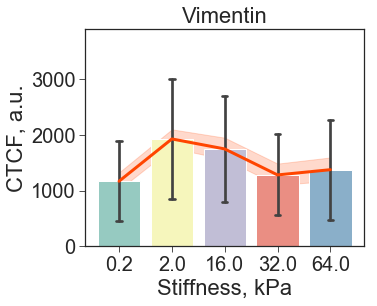

In [282]:
plot_intensities(df, 'vim', 'barplot', 'ctcf', [0, 3900], size=(5, 4), add_line=True)

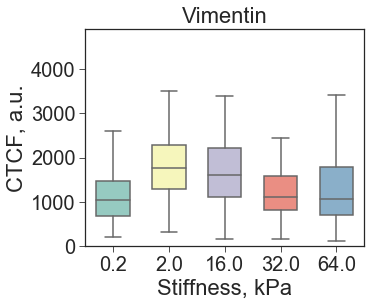

In [283]:
plot_intensities(df, 'vim', 'boxplot', 'ctcf',  [0, 4900], size=(5, 4))

In [ ]:
df.vim.hist(bins=50);

In [ ]:
df.hist(column='vim', by='stiffness', bins=20, 
                sharex=True, sharey=False, 
                layout=(2, 3), figsize=(20, 6));
plt.tight_layout()

In [ ]:
df[['ker']].corrwith(df.vim, method='pearson')

In [ ]:
sns.lmplot(x='ker', y='vim', data=df);

### CV ratio

In [ ]:
df[['ker', 'vim', 'cvratio']].describe()

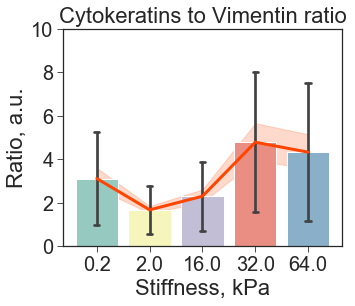

In [284]:
plot_intensities(df, 'cvratio', 'barplot', None, [0, 10], size=(5, 4), add_line=True)

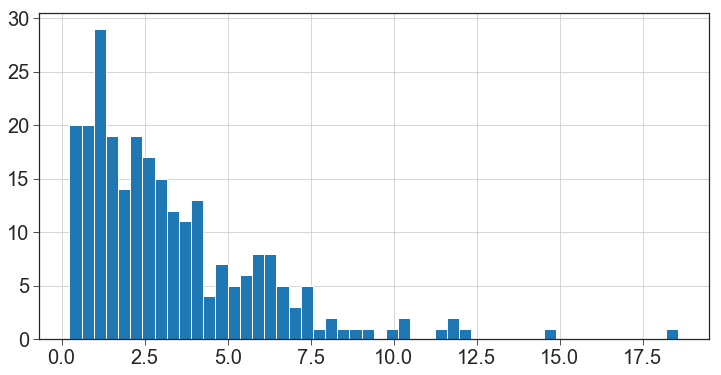

In [209]:
df.cvratio.hist(bins=50, figsize=(12,6));

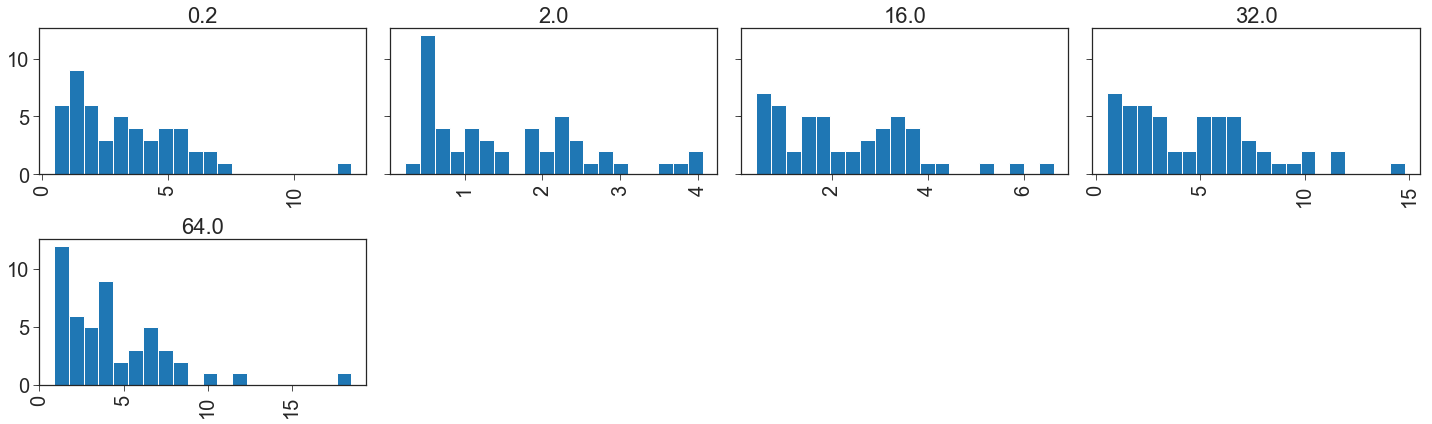

In [210]:
df.hist(column='cvratio', by='stiffness', bins=20, 
                sharex=False, sharey=True, 
                layout=(2, 4), figsize=(20, 6));
plt.tight_layout()

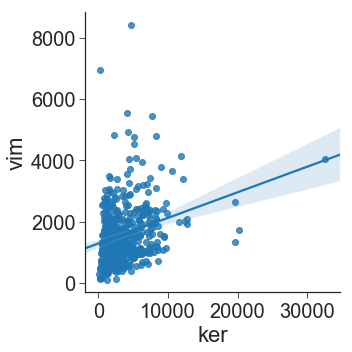

In [285]:
sns.lmplot(x='ker', y='vim', data=df);

In [286]:
df[['ker']].corrwith(df.vim, method='spearman')

ker    0.280523
dtype: float64

###### Remove outliers

In [ ]:
# df = drop_outliers_iqr(df, 'ker')
# df = drop_outliers_iqr(df, 'vim')
# df = drop_outliers_iqr(df, 'ratio')
df.shape

###### Box-Cox transformation

In [ ]:
boxcox_transform(df, 'ker')

In [ ]:
boxcox_transform(df, 'vim')

In [ ]:
sns.boxplot(x=df.stiffness, y=df.ker_t / df.vim_t, palette=palette);

In [ ]:
boxcox_transform(df, 'cvratio')

###### Log transformation

In [ ]:
df['log_ker'] = np.log(df.ker)
df['log_vim'] = np.log(df.vim)
df.shape

In [ ]:
sns.boxplot(x=df.stiffness, y=df.log_ker, palette=palette);
plt.xlabel("Stiffness, kPa")
plt.ylabel("log(Intensity), a.u.")
plt.title("Expression of cytokeratins");
# plt.savefig('../results/log Ker.png', bbox_inches='tight', dpi=300);

In [ ]:
df.log_ker.hist(bins=25, figsize=(12,6));

In [ ]:
df.hist(column='log_ker', by='stiffness', bins=20, 
                sharex=True, sharey=True, 
                layout=(2, 4), figsize=(20, 6));
plt.tight_layout()

In [ ]:
sns.boxplot(x=df.stiffness, y=df.log_vim, palette=palette);
plt.xlabel("Stiffness, kPa")
plt.ylabel("log(Intensity), a.u.")
plt.title("Expression of vimentin");
# plt.savefig('../results/log Vim.png', bbox_inches='tight', dpi=300);

In [ ]:
df.log_vim.hist(bins=25, figsize=(12,6));

In [ ]:
df.hist(column='log_vim', by='stiffness', bins=20, 
                sharex=True, sharey=True, 
                layout=(2, 4), figsize=(20, 6));
plt.tight_layout()

In [ ]:
sns.boxplot(x=df.stiffness, y=df.log_cvratio, palette=palette, showfliers=False);
plt.ylim([-2, 4]);
plt.xlabel("Stiffness, kPa")
plt.ylabel("log(ratio)")
plt.title("Cytokeratin to Vimentin ratio");
# plt.savefig('../results/log CVR.png', bbox_inches='tight', dpi=300);

In [ ]:
sns.boxplot(x=df.stiffness, y=df.log_cvratio, palette=palette, showfliers=False);
plt.ylim([-2, 4]);
plt.xlabel("Stiffness, kPa")
plt.ylabel("log(ratio)")
plt.title("Cytokeratin to Vimentin ratio w/o clusters at 64 kPa");
plt.savefig('../results/log_CVR no clusters.png', bbox_inches='tight', dpi=300);

In [ ]:
df.log_cvratio.hist(bins=25, figsize=(12,6));

In [ ]:
df.hist(column='log_cvratio', by='stiffness', bins=20, 
                sharex=True, sharey=True, 
                layout=(2, 4), figsize=(20, 6));
plt.tight_layout()

## Statistical testing

### Normality tests

In [ ]:
from scipy.stats import anderson, shapiro
group = df.stiffness.unique()
col='vim'
for i in range(len(group)):
    print('\n', group[i])
# Original data
    norm_tests(df.loc[df.stiffness == group[i], col])
# Log transformation
#     norm_tests(np.log(df.loc[df[by] == group[i], col]))
# Box-Cox transformation
#     xt, _= stats.boxcox(df.loc[df[by] == group[i], col])
#     norm_tests(xt)
#     A, crit, sig = anderson(df.loc[df[by] == group[i], col], 'norm')
    

In [ ]:
from statsmodels.graphics.gofplots import qqplot
xt,_ = stats.boxcox(df.loc[df.stiffness == "64.0", 'vim'])
qqplot(xt, line='s');

## Comparison of distributions

In [290]:
def mannwhitneytest(by, col, alternative, transform=None):

    group = df[by].unique()
    for i in range(len(group) - 1):
        x1 = df.loc[df[by] == group[i], col]
        x2 = df.loc[df[by] == group[i + 1], col]
        
        if transform == 'log':
            x1 = np.log(x1)
            x2 = np.log(x2)
        elif transform == 'boxcox':
            x1,_ = stats.boxcox(x1)
            x2,_ = stats.boxcox(x2)
            
        _, p = stats.mannwhitneyu(x1, x2, alternative=alternative)
        if p < 0.001:
            sign = '***'
        elif p < 0.01:
            sign = '**'
        elif p < 0.05:
            sign = '*'
        else:
            sign = ''

        print("A {} Mann Whitney test on samples {} vs {}. {} \t p-value = {:.2}."
              .format(alternative, group[i], group[i + 1],  sign, p))

In [291]:
def welchsttest(by, col, equal_var, transform=None):

    group = df[by].unique()
    for i in range(len(group) - 1):
        x1 = df.loc[df[by] == group[i], col]
        x2 = df.loc[df[by] == group[i + 1], col]
        
        if transform == 'log':
            x1 = np.log(x1)
            x2 = np.log(x2)
        elif transform == 'boxcox':
            x1,_ = stats.boxcox(x1)
            x2,_ = stats.boxcox(x2)
            
        _, p = stats.ttest_ind(x1, x2, equal_var=equal_var)
        if p < 0.001:
            sign = '***'
        elif p < 0.01:
            sign = '**'
        elif p < 0.05:
            sign = '*'
        else:
            sign = ''

        if equal_var:
            print("A two-tailed t-test on samples {} vs {}. {} \t p-value = {:.2}."
                  .format(group[i], group[i + 1],  sign, p))
        else:
            print("Welch's unequal variances t-test on samples {} vs {}. {} \t p-value = {:.2}."
                  .format(group[i], group[i + 1],  sign, p))

In [295]:
mannwhitneytest('stiffness', 'cvratio', alternative='two-sided')

A two-sided Mann Whitney test on samples 0.2 vs 2.0. *** 	 p-value = 1.7e-08.
A two-sided Mann Whitney test on samples 2.0 vs 16.0. ** 	 p-value = 0.0024.
A two-sided Mann Whitney test on samples 16.0 vs 32.0. *** 	 p-value = 9e-07.
A two-sided Mann Whitney test on samples 32.0 vs 64.0.  	 p-value = 0.45.


In [294]:
welchsttest('stiffness', 'cvratio', False)

Welch's unequal variances t-test on samples 0.2 vs 2.0. *** 	 p-value = 1.1e-07.
Welch's unequal variances t-test on samples 2.0 vs 16.0. *** 	 p-value = 0.00083.
Welch's unequal variances t-test on samples 16.0 vs 32.0. *** 	 p-value = 1.2e-06.
Welch's unequal variances t-test on samples 32.0 vs 64.0.  	 p-value = 0.44.


In [139]:
stats.ttest_ind(df.loc[df.stiffness == '0.2', 'cvratio'], 
                df.loc[df.stiffness == '32.0', 'cvratio'],
                equal_var=False)

Ttest_indResult(statistic=-2.780305875190475, pvalue=0.00652922353412384)

In [157]:
def ftest(by, col, transform=None):

    group = df[by].unique()
    for i in range(len(group) - 1):
        x1 = df.loc[df[by] == group[0], col]
        x2 = df.loc[df[by] == group[i + 1], col]

        if transform == 'log':
            x1 = np.log(x1)
            x2 = np.log(x2)
        elif transform == 'boxcox':
            x1,_ = stats.boxcox(x1)
            x2,_ = stats.boxcox(x2)

        _, p = stats.f_oneway(x1, x2)
        if p < 0.001:
            sign = '***'
        elif p < 0.01:
            sign = '**'
        elif p < 0.05:
            sign = '*'
        else:
            sign = ''

        print("An F test on samples {} vs {}. {} \t p-value = {:.2}."
              .format(group[0], group[i + 1],  sign, p))

In [158]:
ftest('stiffness', 'ker')

An F test on samples 0.2 vs 2.0.  	 p-value = 0.35.
An F test on samples 0.2 vs 16.0.  	 p-value = 0.085.
An F test on samples 0.2 vs 32.0. ** 	 p-value = 0.0011.
An F test on samples 0.2 vs 64.0. ** 	 p-value = 0.0031.


## Changes in Vimentin

In [ ]:
df.vim.hist(bins=50);

In [ ]:
# Choose a cutoff for Vimentin expression
cutoff = df.vim.quantile(0.90)
print(cutoff)
df['highvim'] = np.where(df.vim > cutoff, 1, 0)
df.groupby('stiffness').highvim.sum() / df.groupby('stiffness').size() * 100

# Relationship to morphology

## Expression of Vimentin

In [ ]:
palette = sns.color_palette("Set3", 7)

In [ ]:
df = measurements_red

In [ ]:
# Choose a cutoff for Vimentin expression
cutoff = df.meanintensity_vim.quantile(0.90)
df['highvim'] = np.where(df.meanintensity_vim >= cutoff, 1, 0)

In [ ]:
counts = df.groupby(['stiffness', 'image']).highvim.value_counts().unstack().fillna(0)
counts['csum'] = counts.sum(axis=1)
counts['perc1'] = counts.iloc[:, 0] / counts.csum * 100
counts['perc2'] = counts.iloc[:, 1] / counts.csum * 100
counts.reset_index(inplace=True)
counts.head()

In [ ]:
plt.rcParams['figure.figsize'] = (10, 5)

sns.barplot(x='stiffness', y='perc2', 
            data=counts, palette=palette,
            ci='sd', capsize=.1);
plt.xlabel("Stiffness");
plt.ylabel("Percentage");
plt.title("Fraction of cells with high vimentin");
# plt.savefig('../results/high Vim.png', bbox_inches='tight', dpi=300);

In [ ]:
df[geom_cols].corrwith(df.meanintensity_vim).abs().sort_values(ascending=False).head(10)

In [ ]:
df[geom_cols].corrwith(df.meanintensity_vim, method='spearman').abs().sort_values(ascending=False).head(10)

In [ ]:
sns.lmplot(x='ncr', y='meanintensity_vim', data=df, fit_reg=True, legend=False);
plt.xlabel("NCR, a.u.");
plt.ylabel("Vimentin Expression, a.u.");
plt.savefig('../results/Vim vs NCR.png', bbox_inches='tight', dpi=300);

In [ ]:
sns.lmplot(x='area_cell', y='meanintensity_vim', hue='highvim', data=df, fit_reg=False, legend=False);
plt.legend(loc='center', bbox_to_anchor=(0.8, 0.9), fontsize = 'large', 
           labels=['Below 90th percentile', 'Above 90th percentile']);
plt.xlabel("Cell area, px");
plt.ylabel("Vimentin Expression, a.u.");
plt.title("Fraction of cells with high vimentin");
plt.savefig('../results/High vim vs cell area.png', bbox_inches='tight', dpi=300);

In [ ]:
sns.lmplot(x='minferetdiameter_cell', y='meanintensity_vim', hue='highvim', data=df, fit_reg=False);

In [ ]:
sns.lmplot(x='formfactor_cell', y='meanintensity_vim', hue='highvim', data=df, fit_reg=False);

In [ ]:
df[geom_cols].corrwith(df.highvim, method='spearman').abs().sort_values(ascending=False).head(10)

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.boxplot(x=df.highvim, y=df.area_cell);

In [ ]:
sns.boxplot(x=df.highvim, y=df.area_cell);

## Expression of Cytokeratins

In [ ]:
df['highker'] = np.where(df.meanintensity_ker > df.meanintensity_ker.quantile(0.9), 1, 0)

In [ ]:
counts = df.groupby(['stiffness', 'image']).highker.value_counts().unstack().fillna(0)
counts['csum'] = counts.sum(axis=1)
counts.head()

In [ ]:
counts['perc1'] = counts.iloc[:, 0] / counts.csum * 100
counts['perc2'] = counts.iloc[:, 1] / counts.csum * 100
counts.reset_index(inplace=True)
counts.head()

In [ ]:
plt.rcParams['figure.figsize'] = (10, 5)

sns.barplot(x='stiffness', y='perc2', 
            data=counts, palette=palette,
            ci='sd', capsize=.1);
plt.xlabel("Stiffness");
plt.ylabel("Percentage");
plt.title("Percentage of cells with high cytokeratins");

In [ ]:
df[geom_cols].corrwith(df.meanintensity_ker, method='spearman').abs().sort_values(ascending=False).head(10)

In [ ]:
sns.lmplot(x='perimeter_cell', y='meanintensity_ker', hue='highker', data=df, fit_reg=False);

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.boxplot(x=df.highker, y=df.perimeter_cell);

In [ ]:
sns.boxplot(x='stiffness', y='area_cell', data=df);

In [ ]:
sns.boxplot(x='stiffness', y='formfactor_cell', data=df);

## Correlation with log(ratio)

In [ ]:
geom_cols = [col for col in morph_cols if 'dapi' not in col and 'wga' not in col]


p_corr = measurements[geom_cols].corrwith(measurements.log_ratio)

sns.set(rc={'figure.figsize':(15, 2)})

sns.heatmap(pd.DataFrame(p_corr, columns=['Pearsons']).T, 
            cmap=sns.color_palette("RdBu_r", 100), 
            vmin=-1, vmax=1);

In [ ]:
abs(p_corr).sort_values(ascending=False).head(10)

In [ ]:
s_corr = measurements[geom_cols].corrwith(measurements.log_ratio, method='spearman')

sns.set(rc={'figure.figsize':(15, 2)})

sns.heatmap(pd.DataFrame(s_corr, columns=['Spearmans']).T, 
            cmap=sns.color_palette("RdBu_r", 100), 
            vmin=-1, vmax=1);

In [ ]:
top_s_corr_features = abs(s_corr).sort_values(ascending=False).head(10).index
sns.pairplot(pd.concat([measurements[top_s_corr_features], 
                        measurements.log_ratio], 
                       axis=1));

###### Linear Regression

In [ ]:
X = measurements[morph_cols]
y = measurements.log_ratio

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)s
X_test_scaled = scaler.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

y_pred = lin_reg.predict(X_test_scaled)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Testing RMSE:", rmse_test)

print("Null RMSE:", np.sqrt(mean_squared_error(y_test, y_test.apply(lambda x: np.median(y_train)))))

###### Polynomial regression

In [ ]:
X = pd.to_numeric(measurements.stiffness).values.reshape(-1, 1)
y = measurements.log_ratio

poly_features = PolynomialFeatures(degree=3)
X_poly = poly_features.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y)
print(X_train.shape, X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train_scaled, y_train)

y_pred = lasso_reg.predict(X_test_scaled)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Testing RMSE:", rmse_test)

print("Null RMSE:", np.sqrt(mean_squared_error(y_test, y_test.apply(lambda x: np.median(y_train)))))

lasso_reg.coef_

In [ ]:
measurements['stiffness_num'] = pd.to_numeric(measurements.stiffness)
sns.lmplot(x='stiffness_num', y='log_ratio', data=measurements, order=3, height=7, truncate=True);

###### Random Forest regressor

In [ ]:
geom_cols = [col for col in morph_cols if 'dapi' not in col and 'wga' not in col]
cell_cols = [col for col in morph_cols if 'cell' in col]

In [ ]:
X = measurements[morph_cols]
y = np.log(measurements.meanintensity_vim)

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_reg = RandomForestRegressor(n_estimators=1000, max_features=10)
rf_reg.fit(X_train_scaled, y_train)

y_pred = rf_reg.predict(X_test_scaled)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Testing RMSE:", rmse_test)

print("Null RMSE:", np.sqrt(mean_squared_error(y_test, y_test.apply(lambda x: np.median(y_train)))))

In [ ]:
feature_importance = zip(X.columns, rf_reg.feature_importances_)

print("\nFeature importances:")
for col, weight in feature_importance:
    if (weight > 0.02):
        print(col, weight)

importances = rf_reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_reg.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d: (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
measurements['log_ker'] = np.log(measurements.meanintensity_ker)
measurements['log_vim'] = np.log(measurements.meanintensity_vim)
sns.lmplot(x='log_vim', y='area_cell', data=measurements, order=1, height=7);

###### Split ratio values into "low", "medium" and "high"

In [ ]:
def phenotype(df, use, cols=('meanintensity_ker', 'meanintensity_vim')):
    if use=='log_ratio':
        df['log_ratio'] = np.log(df[cols[0]]/df[cols[1]])
        q1 = df.log_ratio.quantile(0.33)
        q3 = df.log_ratio.quantile(0.66)
        df['region'] = pd.cut(df.log_ratio, 
                             bins=(df.log_ratio.min(), q1, q3, df.log_ratio.max()), 
                             labels=["low", "med", "high"], include_lowest=True)
    elif use=='log_biom':
        df['log_ker'] = np.log(df[cols[0]])
        df['log_vim'] = np.log(df[cols[1]])
        df['region'] = "low"
        df.loc[(df.log_ker < df.log_ker.median()) &
                         (df.log_vim > df.log_vim.median()), 'region'] = "high vim"
        df.loc[(df.log_ker > df.log_ker.median()) &
                         (df.log_vim < df.log_vim.median()), 'region'] = "high ker"
        df.loc[(df.log_ker > df.log_ker.median()) &
                         (df.log_vim > df.log_vim.median()), 'region'] = "high"

In [ ]:
phenotype(df, use='log_ratio', cols=('ker', 'vim'))

In [ ]:
sns.set(rc={'figure.figsize':(12, 8)})

sns.scatterplot(x='vim', y='ker', data=df, 
                hue='region', s=50,
                palette=sns.color_palette("Set1", 3));

In [ ]:
df.groupby('stiffness')['region'].value_counts().unstack().plot(kind='bar', stacked=True, legend=False);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 'large');

###### Split ker and vim values into "low" and "high"

In [ ]:
sns.set(rc={'figure.figsize':(12, 8)})

sns.scatterplot(x='log_vim', y='log_ker', data=df, 
                hue='stiffness', s=50,
                palette=sns.color_palette("Set3", 7));

In [ ]:
proc.phenotype(df, use='log_biom', cols=('ker', 'vim'))

In [ ]:
sns.scatterplot(x='vim', y='ker', data=df, 
                hue='region', s=50,
                palette=sns.color_palette("Set1", 4));

In [ ]:
df.groupby('stiffness')['region'].value_counts().unstack().plot(kind='bar', stacked=True, legend=False);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 'large');

###### Random Forest Classifier

In [ ]:
proc.phenotype(measurements, use='log_ratio')
region_num = {'low':0, 'med':1, 'high':2}
# region_num = {'low':0, 'high ker':1, 'high vim':2, 'high':3}

In [ ]:
X = measurements[morph_cols]
y = measurements.region.map(region_num)

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_clf = RandomForestClassifier(n_estimators=1000)
rf_clf.fit(X_train_scaled, y_train)

y_pred = rf_clf.predict(X_test_scaled)
acc_test = accuracy_score(y_test, y_pred)
print("Testing accuraccy:", acc_test)
print("Testing f-score:", f1_score(y_test, y_pred, average='macro'))

most_freq_class = y_train.value_counts().index[0]
print("Most frequent class:", most_freq_class)

n_most_freq = y_test.value_counts()[most_freq_class]
print("Null accuraccy:", n_most_freq / len(y_test))

In [ ]:
# labels = y_test.unique().sort_values()
labels = sorted(y_test.unique())
confusion = confusion_matrix(y_test, y_pred, labels=labels)
confusion_df = pd.DataFrame(confusion, columns=labels, index=labels)
confusion_df

In [ ]:
feature_importance = zip(X.columns, rf_clf.feature_importances_)

print("\nFeature importances:")
for col, weight in feature_importance:
    if (weight > 0.02):
        print(col, weight)

importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d: (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

###### Standartise data

In [ ]:
df['ratio'] = df.ker / df.vim
X = df[['ker', 'vim', 'ratio']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df = pd.concat([df, pd.DataFrame(X_scaled, columns=['ker_scaled', 'vim_scaled', 'ratio_scaled'])], axis=1)
print(X_scaled.shape)

In [ ]:
plt.rcParams['figure.figsize'] = (15, 5)
sns.boxplot(x=df.stiffness, y=df.ker_scaled, palette=palette);

In [ ]:
df.hist(column='ker_scaled', by='stiffness', bins=20, 
                sharex=True, sharey=True, 
                layout=(2, 4), figsize=(20, 6));
plt.tight_layout()

In [ ]:
sns.boxplot(x=df.stiffness, y=df.vim_scaled, palette=palette);

In [ ]:
df.hist(column='vim_scaled', by='stiffness', bins=20, 
                sharex=True, sharey=True, 
                layout=(2, 4), figsize=(20, 6));
plt.tight_layout()

In [ ]:
sns.boxplot(x=df.stiffness, y=df.ker_scaled/df.vim_scaled, palette=palette);

In [ ]:
sns.boxplot(x=df.stiffness, y=df.ratio_scaled, palette=palette);

### Cytokeratin to Vimentin ratio

In [ ]:
biomarkers['ratio'] = biomarkers.meanintensity_ker / biomarkers.meanintensity_vim

In [ ]:
sns.barplot(x=biomarkers.stiffness, y=biomarkers.ratio, 
            estimator=np.mean, ci='sd', capsize=.1, palette=palette);
plt.xlabel("Stiffness, kPa")
plt.ylabel("Mean of the ratio")
plt.title("Ratio of Cytokeratin to Vimentin");
# plt.savefig('../results/Ker to Vim ratio syn.png', bbox_inches='tight', dpi=300);

In [ ]:
sns.boxplot(x=biomarkers.stiffness, y=biomarkers.ratio, palette=palette);
plt.xlabel("Stiffness, kPa")
plt.ylabel("Maximum value")
plt.title("Ratio of Cytokeratin to Vimentin");

In [ ]:
biomarkers.groupby('stiffness').ratio.quantile(0.75).plot(kind='bar');

In [ ]:
sns.set(rc={'figure.figsize':(8, 8)})
sns.scatterplot(x='meanintensity_vim', y='meanintensity_ker', data=biomarkers, 
                hue='stiffness', palette=palette);

#### Histograms

In [ ]:
plt.rcParams['figure.figsize'] = (15, 6)
biomarkers.ratio.hist(bins = 100);
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Histogram of Cytokeratin to Vimentin Ratio");
# plt.savefig('../results/Ker to Vim ratio syn hist.png', bbox_inches='tight', dpi=300);

In [ ]:
biomarkers.hist(column='ratio', by='stiffness', bins=20, 
                sharex=False, sharey=True, 
                layout=(2, 4), figsize=(20, 6));
plt.tight_layout()
# plt.savefig('../results/Ker to Vim ratio syn hist by stiffness.png', bbox_inches='tight', dpi=300);

In [ ]:
sns.boxplot(x=biomarkers.stiffness, y=biomarkers.meanintensity_ker);

In [ ]:
biomarkers.hist(column='meanintensity_ker', by='stiffness', bins=20, 
                sharex=False, sharey=True, 
                layout=(2, 4), figsize=(20, 6));
plt.tight_layout()

In [ ]:
sns.boxplot(x=biomarkers.stiffness, y=biomarkers.meanintensity_vim);

In [ ]:
biomarkers.hist(column='meanintensity_vim', by='stiffness', bins=20, 
                sharex=False, sharey=True, 
                layout=(2, 4), figsize=(20, 6));
plt.tight_layout()

In [ ]:
biomarkers[biomarkers.stiffness=="32.0"].hist(column='ratio', bins=20, figsize=(8, 6));

###### Log transform `ratio`

In [ ]:
biomarkers['log_ratio'] = np.log(biomarkers.ratio)

In [ ]:
sns.barplot(x=biomarkers.stiffness, y=biomarkers.log_ratio, 
            estimator=np.median, ci=None, capsize=.1);
plt.xlabel("Stiffness, kPa")
plt.ylabel("Median of the ln(ratio)")
plt.title("Ratio of Cytokeratin to Vimentin");
# plt.savefig('../results/Ker to Vim ratio.png', bbox_inches='tight', dpi=300);

In [ ]:
biomarkers.log_ratio.hist(bins = 100);
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Histogram of logarithm of Cytokeratin to Vimentin Ratio");
# plt.savefig('../results/Ker to Vim ratio hist.png', bbox_inches='tight', dpi=300);

#### Classification using Random Forest
The distribution of Ker/Vim ratio is bimodal at 16 kPa. Can we predict the ratio and find out which morphological features are highly associated with it?

In [ ]:
stiff16 = measurements.loc[measurements.stiffness=='32.0']
X = stiff16[morph_cols]
y = np.where((stiff16.meanintensity_ker / stiff16.meanintensity_vim) < 3, 0, 1)
 
print("Initial X, y shapes:", X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y)
print("X_train and X_test shapes:", X_train.shape, X_test.shape)

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
print("Testing accuraccy:", accuracy_score(y_test, y_pred))
print("Testing f-score:", f1_score(y_test, y_pred, average='macro'))

feature_importance = zip(feature_cols, rfc.feature_importances_)

print("\nRF feature importance:\n")
for col, weight in feature_importance:
    if (weight > 0.03):
        print(col, weight)

### Clustering

In [ ]:
# Create a feature map
X = measurements[measurements.stiffness=='16.0'].reset_index().drop('index', axis=1)

# Standartise the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[feature_cols])

measurements_scaled = pd.concat([X[meta_cols],
                                 pd.DataFrame(data = X_scaled, columns = feature_cols)], 
                                axis=1)

In [ ]:
measurements_scaled['ratio'] = X.meanintensity_ker / X.meanintensity_vim
measurements_scaled['ratio_bin'] = np.where(measurements_scaled.ratio < 4, 0, 1)

my_palette = dict(zip(measurements_scaled.ratio_bin.unique(), sns.color_palette("Set3", 2)))
row_colors = measurements_scaled.ratio_bin.map(my_palette)


sns.clustermap(measurements_scaled[feature_cols], 
               metric='euclidean', method='ward', 
               col_cluster=False,
               cmap=sns.color_palette('RdBu_r', 100), robust=True,
               row_colors=row_colors);            

In [ ]:
measurements_scaled['ratio'].hist(bins=20, figsize=(8, 6));

#### Linear Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = np.array(pd.to_numeric(intensity.stiffness))
y = intensity.norm_ratio

X.shape, y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

X_train = X_train.reshape((-1, 1))
X_test = X_test.reshape((-1, 1))

X_train.shape, X_test.shape

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
lin_reg.intercept_, lin_reg.coef_

In [ ]:
y_pred = lin_reg.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

#### Polynomial regression

In [ ]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

X_train_poly.shape, X_test_poly.shape

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
lin_reg.intercept_, lin_reg.coef_

In [ ]:
y_pred = lin_reg.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

In [ ]:
stiffness = [0.2, 0.5, 2.0, 8.0, 16.0, 32.0, 64.0]

#### K-Means

In [ ]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

#X = np.array(intensity.norm_ratio).reshape((-1, 1))
X = np.array(intensity[['normintensity_ker', 'normintensity_vim']])

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

In [ ]:
intensity['cluster'] = km.labels_
km.labels_

In [ ]:
# Group by clusters and calculate the mean of each feature.
intensity.groupby('cluster').mean()

In [ ]:
sns.scatterplot(data=intensity, x='normintensity_ker', y='normintensity_vim', 
                hue='stiffness', palette=sns.color_palette("husl", 7), s=100);
plt.xlim(0, 70)
plt.ylim(0, 70)

In [ ]:
pd.crosstab(intensity.stiffness, intensity.cluster)

### Statistical testing

#### Check parametric assumptions

In [ ]:
biomarkers.groupby("stiffness").meanintensity_ker.describe()

In [ ]:
biomarkers.hist(column='meanintensity_vim', by='stiffness', sharex=True, sharey=True);

In [ ]:
biomarkers.groupby("stiffness").meanintensity_vim.describe()

#### Two-sample t-test

###### Keratin

In [ ]:
from scipy.stats import mannwhitneyu, ttest_ind

print("Background in keratin channel:\n")

t, p = ttest_ind(biomarkers[biomarkers.stiffness == "0.2"].meanintensity_ker,
                 biomarkers[biomarkers.stiffness == "2.0"].meanintensity_ker)
print("0.2 kPa vs 2.0 kPa \t p-value =", p)

t, p = ttest_ind(biomarkers[biomarkers.stiffness == "2.0"].meanintensity_ker,
                 biomarkers[biomarkers.stiffness == "16.0"].meanintensity_ker)
print("2.0 kPa vs 16.0 kPa \t p-value =", p)

t, p = ttest_ind(biomarkers[biomarkers.stiffness == "16.0"].meanintensity_ker,
                 biomarkers[biomarkers.stiffness == "32.0"].meanintensity_ker)
print("16.0 kPa vs 32.0 kPa \t p-value =", p)
      
t, p = ttest_ind(biomarkers[biomarkers.stiffness == "32.0"].meanintensity_ker,
                 biomarkers[biomarkers.stiffness == "64.0"].meanintensity_ker, 
                 equal_var=False)
print("32.0 kPa vs 64.0 kPa \t p-value =", p)

###### Vimentin

In [ ]:
print("Intensity in vimentin channel:\n")

t, p = ttest_ind(biomarkers[biomarkers.stiffness == "0.2"].meanintensity_vim,
                 biomarkers[biomarkers.stiffness == "2.0"].meanintensity_vim, 
                 equal_var=False)
print("0.2 kPa vs 2.0 kPa \t p-value =", p)

t, p = ttest_ind(biomarkers[biomarkers.stiffness == "2.0"].meanintensity_vim,
                 biomarkers[biomarkers.stiffness == "16.0"].meanintensity_vim, 
                 equal_var=False)
print("2.0 kPa vs 16.0 kPa \t p-value =", p)

t, p = ttest_ind(biomarkers[biomarkers.stiffness == "16.0"].meanintensity_vim,
                 biomarkers[biomarkers.stiffness == "32.0"].meanintensity_vim, 
                 equal_var=False)
print("16.0 kPa vs 32.0 kPa \t p-value =", p)
      
t, p = ttest_ind(biomarkers[biomarkers.stiffness == "32.0"].meanintensity_vim,
                 biomarkers[biomarkers.stiffness == "64.0"].meanintensity_vim, 
                 equal_var=False)
print("32.0 kPa vs 64.0 kPa \t p-value =", p)

## Create dataframes for Keratin and Vimentin

In [ ]:
channels = ['ker', 'vim']
keratin, vimentin = prep.split_dataset(biomarkers_, channels=channels)

In [ ]:
print(keratin.shape, vimentin.shape)

## Correlations between features

### Keratin

In [ ]:
keratin_ = keratin.copy()
keratin_['stiffness_num'] = pd.to_numeric(keratin_.stiffness)

In [ ]:
correlations = keratin_.corr();

In [ ]:
plt.rcParams['figure.figsize'] = (12, 10)

sns.heatmap(correlations, cmap=sns.color_palette("PRGn_r", 100), vmin=-1, vmax=1);

plt.savefig('../results/Keratin Correlations.png', bbox_inches='tight', dpi=300);

In [ ]:
correlations.stiffness_num

### Vimentin

In [ ]:
vimentin_ = vimentin.copy()
vimentin_['stiffness_num'] = pd.to_numeric(vimentin_.stiffness)

In [ ]:
correlations = vimentin_.corr();

In [ ]:
plt.rcParams['figure.figsize'] = (12, 10)

sns.heatmap(correlations, cmap=sns.color_palette("PRGn_r", 100), vmin=-1, vmax=1);

plt.savefig('../results/Vimentin Correlations.png', bbox_inches='tight', dpi=300);

In [ ]:
correlations.stiffness_num

## Explore groups of features

### Keratin

In [ ]:
list(keratin_.columns)

###### Intensity

In [ ]:
intensity = pd.concat([keratin_.loc[:, 'integratedintensityedge' : 'stdintensity'], keratin_.stiffness_num], axis=1) 
print(intensity.shape)

In [ ]:
# Transformations
group['log_majoraxislength_cell'] = np.log(group['majoraxislength_cell'])
#group['log_eccentricity_cell'] = np.log(group['eccentricity_cell'])
group['majoraxislength_cell'].hist();

In [ ]:
sns.heatmap(intensity.corr(), cmap=sns.color_palette("PRGn_r", 100), vmin=-1, vmax=1);

In [ ]:
edge_intensity = intensity[[col for col in group.columns if 'edge' in col]]
edge_intensity.head()

In [ ]:
sns.heatmap(edge_intensity.corr(), annot=True, cmap=sns.color_palette("PRGn_r", 100), vmin=-1, vmax=1);

In [ ]:
sns.pairplot(edge_intensity, height=3);

## Clustering

### K-Means

In [ ]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

X = biomarkers_[feature_cols]

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

In [ ]:
# Review cluster labels.
km.labels_

In [ ]:
#Save the cluster labels and sort by cluster.
biomarkers_['cluster'] = km.labels_
biomarkers_.sort_values('cluster')

In [ ]:
# Review the custer centers.
km.cluster_centers_.shape

In [ ]:
# Group by clusters and calculate the mean of each feature.
biomarkers_.groupby('cluster').mean()

In [ ]:
# Save the `DataFrame` of cluster centroids.
centroids = biomarkers_.groupby('cluster').mean()

In [ ]:
colors = sns.color_palette("husl", 5)

sns.scatterplot(data=biomarkers_, x='meanintensityedge_origker', y='meanintensityedge_origvim', 
                s=100, hue='stiffness_num', palette=colors);

In [ ]:
colors = sns.color_palette("husl", 3)

sns.scatterplot(data=biomarkers_, x='meanintensityedge_origker', y='meanintensityedge_origvim', 
                s=100, hue='cluster', palette=colors);

sns.scatterplot(data=centroids, x='meanintensityedge_origker', y='meanintensityedge_origvim', 
                linewidth=3, marker='x', 
                s=200, color='black');

In [ ]:
pd.crosstab(biomarkers_.stiffness_num, biomarkers_.cluster)

### DBSCAN

In [ ]:
X = biomarkers_[feature_cols]

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
db = DBSCAN(eps=0.001, min_samples=3)
db.fit(X_scaled)

In [ ]:
# Review the cluster labels.
db.labels_

### Agglomerative clustering

In [ ]:
biomarkers_norm = biomarkers_.copy()
# Standardise the entire dataset
biomarkers_norm[feature_cols] = (biomarkers_norm[feature_cols] - biomarkers_norm[feature_cols].mean()) / biomarkers_norm[feature_cols].std()

In [ ]:
# Prepare a vector of colours mapped to the 'stiffness' column
my_palette = dict(zip(biomarkers_norm.stiffness.unique(), sns.color_palette("Set3", 5)))
row_colors = biomarkers_norm.stiffness.map(my_palette)

print(my_palette.keys())
sns.palplot(my_palette.values())

In [ ]:
sns.clustermap(biomarkers_norm[feature_cols], 
               metric='euclidean', method='ward', 
               col_cluster=False,
               cmap=sns.color_palette('RdBu_r', 100), robust=True, 
               row_colors=row_colors);

#plt.savefig('../results/Clustering.png', bbox_inches='tight', dpi=300);

## Intensity by stiffness

### Keratin

In [ ]:
keratin['total_px'] = keratin['Intensity_IntegratedIntensity_OrigKer'] / keratin['Intensity_MeanIntensity_OrigKer']
keratin['edge_px'] = keratin['Intensity_IntegratedIntensityEdge_OrigKer'] / keratin['Intensity_MeanIntensityEdge_OrigKer']

In [ ]:
keratin.head(3)

In [ ]:
keratin['IntegratedIntensityInner'] = keratin['Intensity_IntegratedIntensity_OrigKer'] - keratin['Intensity_IntegratedIntensityEdge_OrigKer']

keratin['MeanIntensityInner'] = keratin['IntegratedIntensityInner'] / (keratin['total_px'] - keratin['edge_px'])

In [ ]:
intensity_cols = ['Intensity_IntegratedIntensity_OrigKer', 
                  'IntegratedIntensityInner', 
                  'Intensity_IntegratedIntensityEdge_OrigKer']

fig, ax = plt.subplots()
keratin.groupby('stiffness')[intensity_cols].mean().plot(kind='bar', 
                                                         title="Integrated intensity of Cytokeratin", 
                                                         fontsize=14,
                                                         ax=ax);
ax.legend(["Integrated Intensity", "Integrated Inner Intensity", "Integrated Edge Intensity"], fontsize=14);

In [ ]:
intensity_cols = ['Intensity_MeanIntensity_OrigKer', 
                  'MeanIntensityInner', 
                  'Intensity_MeanIntensityEdge_OrigKer']

fig, ax = plt.subplots()
keratin.groupby('stiffness')[intensity_cols].mean().plot(kind='bar', 
                                                         title="Mean intensity of Cytokeratin", 
                                                         fontsize=14,
                                                         ax=ax);
ax.legend(["Mean Intensity", "Mean Inner Intensity", "Mean Edge Intensity"], fontsize=14);

plt.savefig('../results/Cytokeratin Mean Intensity.png', bbox_inches='tight', dpi=300);

### Vimentin

In [ ]:
vimentin['total_px'] = vimentin['Intensity_IntegratedIntensity_OrigVim'] / vimentin['Intensity_MeanIntensity_OrigVim']
vimentin['edge_px'] = vimentin['Intensity_IntegratedIntensityEdge_OrigVim'] / vimentin['Intensity_MeanIntensityEdge_OrigVim']

In [ ]:
vimentin.head(3)

In [ ]:
vimentin['IntegratedIntensityInner'] = vimentin['Intensity_IntegratedIntensity_OrigVim'] - vimentin['Intensity_IntegratedIntensityEdge_OrigVim']

vimentin['MeanIntensityInner'] = vimentin['IntegratedIntensityInner'] / (vimentin['total_px'] - vimentin['edge_px'])

In [ ]:
intensity_cols = ['Intensity_IntegratedIntensity_OrigVim', 
                  'IntegratedIntensityInner', 
                  'Intensity_IntegratedIntensityEdge_OrigVim']

fig, ax = plt.subplots()
vimentin.groupby('stiffness')[intensity_cols].mean().plot(kind='bar', 
                                                         title="Integrated intensity of Vimentin", 
                                                         fontsize=14,
                                                         ax=ax);
ax.legend(["Integrated Intensity", "Integrated Inner Intensity", "Integrated Edge Intensity"], fontsize=14);

In [ ]:
intensity_cols = ['Intensity_MeanIntensity_OrigVim', 
                  'MeanIntensityInner', 
                  'Intensity_MeanIntensityEdge_OrigVim']

fig, ax = plt.subplots()
vimentin.groupby('stiffness')[intensity_cols].mean().plot(kind='bar', 
                                                         title="Mean intensity of Vimentin", 
                                                         fontsize=14,
                                                         ax=ax);
ax.legend(["Mean Intensity", "Mean Inner Intensity", "Mean Edge Intensity"], fontsize=14);

plt.savefig('../results/Vimentin Mean Intensity.png', bbox_inches='tight', dpi=300);